# LGBIO2060 Exercice session 4

#Hidden markov model

__Authors:__ Simon Vandergooten, Clémence Vandamme

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy


##Introduction and context
In this tutorial the models developed in the last sessions will get a bit more complex. Until now, we have used binary or continuous variables whose state was fixed in time. It is easy to see that this greatly limits our ability to represent real systems. One way to get closer to reality would be to allow our hidden states to change their values. 

Let's take the example of the fish. Previously they were either on the right or on the left. But now, we will add to the model the fact that fishes can switch side. 

It is exactly what **Hidden markov models** permits. The Markov property specifies that you can fully encapsulate the important properties of a system based on its current state at the current time. Any previous history does not matter, it is memoryless. Back to the fishes, it means that the school of fish is only at one position at a time and the probability of them being on the left or on the right at time *t* depends only on the state at time *t-1*.  The probabilities of transition from one state to another can be represented with a matrix called the **transition matrix**.

<img alt='Solution hint' align='left' width=650 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/HMM.png>


We can use linear algebra to express the probabilities of the current state.

$$P_i = [P(state_i = right), P(state_i = left) ] $$

To compute the vector of probabilities of the state at the time i+1, we can use linear algebra and multiply our vector of the probabilities of the current state with the transition matrix.

$$P_{i+1} = P_{i} T$$
where $T$ is our transition matrix.

This is the same formula for every step, which allows us to get the probabilities for a time more than 1 step in advance easily. If we started at $i=0$ and wanted to look at the probabilities at step $i=2$, we could do:

\begin{align*}
P_{1} &= P_{0}T\\
P_{2} &= P_{1}T = P_{0}TT = P_{0}T^2\\
\end{align*}

So, every time we take a further step we can just multiply with the transition matrix again. So, the probability vector of states at j timepoints after the current state at timepoint i is equal to the probability vector at timepoint i times the transition matrix raised to the jth power.
$$P_{i + j} = P_{i}T^j $$

By the end of this tutorial, you should be able to:
- Describe how the hidden states in a Hidden Markov model evolve over time, both in words, mathematically, and in code
- Estimate hidden states from data using forward inference in a Hidden Markov model
- Describe how measurement noise and state transition probabilities affect uncertainty in predictions in the future and the ability to estimate hidden states.

# Section 1: Binary HMM with Gaussian measurements
We will represent the hidden state *s* of the fish with the values +1 and -1 for the right and left position respectively. 

The probability of switching to state $s_t=j$ from the previous state $s_{t-1}=i$ is the conditional probability distribution $p(s_t = j| s_{t-1} = i)$.

In our case, we can summarize those transition probabilities into the **Transition matrix T**.

\begin{align*}
T = \begin{bmatrix}p(s_t = +1 | s_{t-1} = +1) & p(s_t = -1 | s_{t-1} = +1)\\p(s_t = +1 | s_{t-1} = -1)& p(s_t = -1 | s_{t-1} = -1)\end{bmatrix}
\end{align*}

###Measurements
In a Hidden Markov model, we cannot directly observe the latent states $s_t$. Instead we get noisy measurements $m_t \sim p(m|s_t)$

In [1]:
#@title Imports

import numpy as np
import time
from scipy import stats
from scipy.optimize import linear_sum_assignment
from collections import namedtuple

import matplotlib.pyplot as plt
from matplotlib import patches

In [2]:
#@title Figure Settings
# import ipywidgets as widgets       # interactive display
from IPython.html import widgets
from ipywidgets import interactive, interact, HBox, Layout,VBox
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
# @title Plotting Functions

def plot_hmm1(noise_level, states, measurements, flag_m=True):
  """Plots HMM states and measurements for 1d states and measurements.

  Args:
    model (hmmlearn model):               hmmlearn model used to get state means.
    states (numpy array of floats):       Samples of the states.
    measurements (numpy array of floats): Samples of the states.
  """
  #Correction to avoid model
  means_vec = np.array([1., -1.])
  n_components = 2
  vars_vec = np.ones(2) * noise_level * noise_level

  T = states.shape[0]
  nsteps = states.size
  aspect_ratio = 2
  fig, ax1 = plt.subplots(figsize=(8,4))
  #states_forplot = list(map(lambda s: means_vec[s], states))
  ax1.step(np.arange(nstep), states, "-", where="mid", alpha=1.0, c="green")
  ax1.set_xlabel("Time")
  ax1.set_ylabel("Latent State", c="green")
  ax1.set_yticks([-1, 1])
  ax1.set_yticklabels(["-1", "+1"])
  ax1.set_xticks(np.arange(0,T,10))
  ymin = min(measurements)
  ymax = max(measurements)

  ax2 = ax1.twinx()
  ax2.set_ylabel("Measurements", c="crimson")

  # show measurement gaussian
  if flag_m:
    ax2.plot([T,T],ax2.get_ylim(), color="maroon", alpha=0.6)
    for i in range(n_components):
      mu = means_vec[i]
      scale = np.sqrt(vars_vec[i])
      rv = stats.norm(mu, scale)
      num_points = 50
      domain = np.linspace(mu-3*scale, mu+3*scale, num_points)

      left = np.repeat(float(T), num_points)
      # left = np.repeat(0.0, num_points)
      offset = rv.pdf(domain)
      offset *= T / 15
      lbl = "measurement" if i == 0 else ""
      # ax2.fill_betweenx(domain, left, left-offset, alpha=0.3, lw=2, color="maroon", label=lbl)
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="maroon", label=lbl)
      ax2.scatter(np.arange(nstep), measurements, c="crimson", s=4)
      ax2.legend(loc="upper left")
    ax1.set_ylim(ax2.get_ylim())
  plt.show(fig)


def plot_marginal_seq(predictive_probs, switch_prob):
  """Plots the sequence of marginal predictive distributions.

    Args:
      predictive_probs (list of numpy vectors): sequence of predictive probability vectors
      switch_prob (float):                      Probability of switching states.
  """
  T = len(predictive_probs)
  prob_neg = [p_vec[1] for p_vec in predictive_probs]
  prob_pos = [p_vec[0] for p_vec in predictive_probs]
  fig, ax = plt.subplots()
  ax.plot(np.arange(T), prob_neg, color="blue")
  ax.plot(np.arange(T), prob_pos, color="orange")
  ax.legend([
    "prob in state -1", "prob in state 1"
  ])
  ax.text(T/2, 0.05, "switching probability from right to left={}".format(switch_prob), fontsize=12,
          bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.6))
  ax.set_xlabel("Time")
  ax.set_ylabel("Probability")
  ax.set_title("Forgetting curve in a changing world")
  #ax.set_aspect(aspect_ratio)
  plt.show(fig)


def plot_evidence_vs_noevidence(posterior_matrix, predictive_probs):
  """Plots the average posterior probabilities with evidence v.s. no evidence

  Args:
    posterior_matrix: (2d numpy array of floats): The posterior probabilities in state 1 from evidence (samples, time)
    predictive_probs (numpy array of floats):  Predictive probabilities in state 1 without evidence
  """
  nsample, T = posterior_matrix.shape
  posterior_mean = posterior_matrix.mean(axis=0)
  fig, ax = plt.subplots(1)
  # ax.plot([0.0, T],[0.5, 0.5], color="red", linestyle="dashed")
  ax.plot([0.0, T],[0., 0.], color="red", linestyle="dashed")
  ax.plot(np.arange(T), predictive_probs, c="orange", linewidth=2, label="No evidence")
  ax.scatter(np.tile(np.arange(T), (nsample, 1)), posterior_matrix, s=0.8, c="green", alpha=0.3, label="With evidence(Sample)")
  ax.plot(np.arange(T), posterior_mean, c='green', linewidth=2, label="With evidence(Average)")
  ax.legend()
  ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
  ax.set_xlabel("Time")
  ax.set_ylabel("Probability in State +1")
  ax.set_title("Gain confidence with evidence")
  plt.show(fig)


def plot_forward_inference(noise_level, states, measurements, states_inferred,
                           predictive_probs, likelihoods, posterior_probs,
                           t=None,
                           flag_m=True, flag_d=True, flag_pre=True, flag_like=True, flag_post=True,
                           ):
  """Plot ground truth state sequence with noisy measurements, and ground truth states v.s. inferred ones

      Args:
          model (instance of hmmlearn.GaussianHMM): an instance of HMM
          states (numpy vector): vector of 0 or 1(int or Bool), the sequences of true latent states
          measurements (numpy vector of numpy vector): the un-flattened Gaussian measurements at each time point, element has size (1,)
          states_inferred (numpy vector): vector of 0 or 1(int or Bool), the sequences of inferred latent states
  """
  #Correction to avoid model
  means_vec = np.array([1., -1.])
  n_components = 2
  vars_vec = np.ones(2) * noise_level * noise_level

  T = states.shape[0]
  if t is None:
    t = T-1
  nsteps = states.size
  fig, ax1 = plt.subplots(figsize=(11,6))
  # inferred states
  #ax1.step(np.arange(nstep)[:t+1], states_forplot[:t+1], "-", where="mid", alpha=1.0, c="orange", label="inferred")
  # true states
  #states_forplot = list(map(lambda s: model.means[s], states))
  ax1.step(np.arange(nstep)[:t+1], states[:t+1], "-", where="mid", alpha=1.0, c="green", label="true")
  ax1.step(np.arange(nstep)[t+1:], states[t+1:], "-", where="mid", alpha=0.3, c="green", label="")
  # Posterior curve
  delta = means_vec[1] - means_vec[0]
  states_interpolation = means_vec[0] + delta * posterior_probs[:,1]
  if flag_post:
    ax1.step(np.arange(nstep)[:t+1], states_inferred[:t+1], "-", where="mid", c="grey", label="posterior")

  ax1.set_xlabel("Time")
  ax1.set_ylabel("Latent State", c="green")
  ax1.set_yticks([-1, 1])
  ax1.set_yticklabels(["-1", "+1"])
  ax1.legend(bbox_to_anchor=(0,1.02,0.2,0.1), borderaxespad=0, ncol=2)
  


  ax2 = ax1.twinx()
  ax2.set_ylim(
      min(-1.2, np.min(measurements)),
      max(1.2, np.max(measurements))
      )
  if flag_d:
    ax2.scatter(np.arange(nstep)[:t+1], measurements[:t+1], c="crimson", s=4, label="measurement")
    ax2.set_ylabel("Measurements", c="crimson")
  
  # show measurement distributions
  if flag_m:
    for i in range(n_components):
      mu = means_vec[i]
      scale = np.sqrt(vars_vec[i])
      rv = stats.norm(mu, scale)
      num_points = 50
      domain = np.linspace(mu-3*scale, mu+3*scale, num_points)

      left = np.repeat(float(T), num_points)
      offset = rv.pdf(domain)
      offset *= T /15
      # lbl = "measurement" if i == 0 else ""
      lbl = ""
      # ax2.fill_betweenx(domain, left, left-offset, alpha=0.3, lw=2, color="maroon", label=lbl)
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="maroon", label=lbl)
  ymin, ymax = ax2.get_ylim()
  width = 0.1 * (ymax-ymin) / 2.0
  centers = [-1.0, 1.0]
  bar_scale = 15
  
  # Predictions
  data = predictive_probs
  if flag_pre:
    for i in range(n_components):
      domain = np.array([centers[i]-1.5*width, centers[i]-0.5*width])
      left = np.array([t,t])
      offset = np.array([data[t,i]]*2)
      offset *= bar_scale
      lbl = "todays prior" if i == 0 else ""
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="dodgerblue", label=lbl)

  # Likelihoods
  # data = np.stack([likelihoods, 1.0-likelihoods],axis=-1)
  data = likelihoods
  data /= np.sum(data,axis=-1, keepdims=True)
  if flag_like:
    for i in range(n_components):
      domain = np.array([centers[i]+0.5*width, centers[i]+1.5*width])
      left = np.array([t,t])
      offset = np.array([data[t,i]]*2)
      offset *= bar_scale
      lbl = "likelihood" if i == 0 else ""
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="crimson", label=lbl)
  # Posteriors
  data = posterior_probs
  if flag_post:
    for i in range(n_components):
      domain = np.array([centers[i]-0.5*width, centers[i]+0.5*width])
      left = np.array([t,t])
      offset = np.array([data[t,i]]*2)
      offset *= bar_scale
      lbl = "posterior" if i == 0 else ""
      ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="grey", label=lbl)
  if t<T-1:
    ax2.plot([t,t],ax2.get_ylim(), color='black',alpha=0.6)
  if flag_pre or flag_like or flag_post:
    ax2.plot([t,t],ax2.get_ylim(), color='black',alpha=0.6)

    ax2.legend(bbox_to_anchor=(0.4,1.02,0.6, 0.1), borderaxespad=0, ncol=4)
  ax1.set_ylim(ax2.get_ylim())
  return fig
  # plt.show(fig)

##Coding exercice 1.1 : Hidden states
You will first implement the function `generate_state`. This function will create the vector of states *S* based on the model parameters.

In [36]:
def generate_state(switch_proba, start_proba, n_states):
  '''
  Create an HMM binary state variable.
  Args:
    switch_proba (array): the probabilities to switch from states. [p(rightToLeft), p(LeftToRight)]
    start_proba (array): the initial probabilities of being on each side. P0 = [p_right, p_left]
    n_states (int): the number of time steps

  Returns:
    S (array): the vector of state for each time step.
  '''
  ##########################
  ##### Your code here #####
  ##########################
  #Initialize S
  S = np.zeros((n_states,),dtype=int)

  #Step 1: Initial state (Hint: np.random.choice)
  S[0] = np.random.choice([1,-1],p=start_proba)

  #Step 2: Transition matrix
  T = np.array([[1. - switch_proba[0], switch_proba[0]], [switch_proba[1], 1. - switch_proba[1]]]) 
  
  #Step 3: Iterate on each time step to find the new state s[t] based on S[t-1]
  for i in range(1,n_states):
    transition_vector = T[S[i-1],:]
    S[i] = np.random.choice([1,-1],p=transition_vector)
  return S

#Set random seed
np.random.seed(54)

#Set parameters of HMM
switch_proba = np.array([0.4, 0.7])
start_proba = np.array([0, 1]) #The initial state is left (-1)
n_states = 50

#Generate the hidden states vector
S = generate_state(switch_proba, start_proba, n_states)

#Print values
print(S[:5])

[-1  1  1  1  1]


You should see that the first five states are:
 
 `[-1.  1.  1.  1.  1.]`

##Coding exercice 1.2 : Noisy measurements
Now that you have created the hidden states, you will create the noisy Gaussian measurements vector *M* from these states.

Recall that in reality we don't have access to the hidden states but only to noisy measurements that give us information about those hidden states we want to infer.

You will implement the function `sample` that generates samples $m_t$ based on the hidden states $s_t$. 
- if hidden state $s_t = +1 $ : $m_t \sim \mathcal{N}(+1,\sigma^2)$
- if hidden state $s_t = -1 $ : $m_t \sim \mathcal{N}(-1,\sigma^2)$

Back to the fish example, the measurement could be for example the position of a fish you managed to see. It is noisy because of water refraction as well as the imperfection of the visual system. 

In [47]:
def sample(means, var, S):
  '''
  Create a Gaussian measurement from HMM states

    Args: 
      means (array): Mean measurement for each state [right, left].
      var (float): Variance of measurement models. Same for each state.
      S (array): The series of hidden states.
    
    Returns:
      M (array): The series of measurements.
  '''
  ##########################
  ##### Your code here #####
  ##########################
  
  #Initialize measurements vector M
  M = np.zeros(len(S))

  #Calculate measurements conditioned on the latent states (Hint: np.random.normal)
  print(means[S])
  M = np.random.normal(loc=-means[S],scale=np.sqrt(var),size=(len(S),))

  return M

#Set parameters of Gaussian 
np.random.seed(54)
means = np.array([1, -1])
variance = 4

#Generate the measurements vector M
M = sample(means, variance, S)

#Print values
print(M[:5])

[ 1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1
  1 -1]
[-4.70442149 -1.16199798  1.15712765 -1.70827118  2.25229692]


You should see that the first five measurements are:
 
 `[-4.70442149 -1.16199798  1.15712765 -1.70827118  2.25229692]`

# Interactive Demo 1.2: Binary HMM

In the demo below, we simulate and plot a similar HMM. You can change the probability of switching states and the noise level (the standard deviation of the Gaussian distributions for measurements). You can click the empty box to also visualize the measurements.

**First**, think about and discuss these questions:

1.   What will the states do if the switching probability from Left to Right is zero? One?
2.   What will measurements look like with high noise? Low?



**Then**, play with the demo to see if you were correct or not.

In [7]:
#@title

#@markdown Execute this cell to enable the widget!
nstep = 100

@widgets.interact
def plot_samples_widget(
    switch_RtoL=widgets.FloatSlider(min=0.0, max=1.0, step=0.02, value=0.1),
    switch_LtoR=widgets.FloatSlider(min=0.0, max=1.0, step=0.02, value=0.1),
    log10_noise_level=widgets.FloatSlider(min=-1., max=1., step=.01, value=-0.3),
    flag_m=widgets.Checkbox(value=False, description='measurements', disabled=False, indent=False)
    ):
  np.random.seed(54)
  #Parameters
  switch_proba = np.array([switch_RtoL, switch_LtoR])
  start_proba = np.array([0, 1])
  means = np.array([1., -1.])
  var = np.ones(2) * 10.**log10_noise_level * 10.**log10_noise_level

  states = generate_state(switch_proba, start_proba, nstep)
  observations = sample(means, var[0], states)

  plot_hmm1(10.**log10_noise_level, states, observations, flag_m=flag_m)

interactive(children=(FloatSlider(value=0.1, description='switch_RtoL', max=1.0, step=0.02), FloatSlider(value…

#Section 2: Predicting the future in an HMM
Even if we know the world state for sure, the world changes. We will become less and less confident on the states as time goes if we do not add any measurement. In this exercise, we'll see how a Hidden Markov Model gradually "forgets" the current state when predicting the future without measurements.



##Coding exercice 2.1: future without measurements
Assume we know the initial state $s_0 = -1$, so $p(s_0)=[0, 1]$. We will plot $p(s_t)$ versus time.

You will implement the function `simulate_prediction_only` which simulates the diffusion of a HMM with no measurement.
In practice, you will iteratively implement a **one step prediction** using the dynamic of the HMM and the previous probability vector to compute the next one.

In [50]:
def simulate_prediction_only(nstep, T):
  '''
  Simulate the diffusion of HMM with no measurements.

    Args:
      nstep (int): total number of time steps to simulate
      T (array): transition matrix of the HMM

    Returns:
      predictive_probs (list of numpy vector): the list of maginal probabilities
  '''
  #Initialization
  predictive_probs = []

  ##########################
  ##### Your code here #####
  ##########################
  p0 = [0,1]
  for i in range(nstep):
    predictive_probs.append(p0)
    p0 = p0@T
  
  #Compute the probability vector for each time step

  return predictive_probs


### Interactive Demo 2.1: Forgetting in a changing world
Using the following widget manipulate the process dynamics via the slider controlling the switching probabilities.

- What happens when both probabilities are the same ? And when they are not ?

- How does the curves look when both `switch_RtoL` and `switch_LtoR` are 0.05 ? 0.95 ?

- Do you forget more quickly with high or low switching probabilities ? Why ?

In [51]:
#@markdown Execute this cell to enable the widget
noise_level = 0.5
nsteps = 100
np.random.seed(54)
@widgets.interact
def plot_samples_widget(
    switch_RtoL=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1),
    switch_LtoR=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1)):
  np.random.seed(54)
  transition_matrix = np.array([[1. - switch_RtoL, switch_RtoL],
                                [switch_LtoR, 1. - switch_LtoR]])
  predictive_probs = simulate_prediction_only(nsteps, transition_matrix)
  plot_marginal_seq(predictive_probs, switch_RtoL)

interactive(children=(FloatSlider(value=0.1, description='switch_RtoL', max=1.0, step=0.01), FloatSlider(value…

#Section 3: Forward inference in an HMM
Now that we have seen that it is not possible to do predictions without using  measurements, we will see how it is possible using Bayesian theory.

It will be a recursive algorithm. Let's assume we already have yesterday's posterior $p(s_{t-1}|m_{1:t-1})$ which is our belief of the state of yesterday based on all the previous measurements. When the new data $m_t$ comes in, the algorithm performs the following steps:

- **Predict**: Tranform yesterday's posterior over $s_{t-1}$ into today's prior over $s_t$ using the transition $T$. 
- **Update**: Incorporate measurement $m_t$ to calculate the posterior $p(s_t|m_{1:t})$

Today's prior and the posterior are illustrated in the following picture.


<img alt='Solution hint' align='left' width=800 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/TP4_posterior.PNG>



## Coding Exercise 3.1: Forward inference of HMM
In this exercise, you will:

* STEP 1: Complete the code in function `compute_likelihood` to calculate the likelihood of seeing data 'M' for all measurement models.

* STEP 2: Complete the code in function `one_step_update` to combine predictive probabilities and data likelihood into a new posterior.

* STEP 3: Complete the code in the function `forward inference` which calls `one_step_update` recursively.

In [62]:
def compute_likelihood(means, var, M):
  """
  Calculate likelihood of seeing data `M` for all measurement models

  Args:
    means (array): Mean mesurement for each state [right, left].
    var (float): Variance of measurement models. Same for each state.
    M (float or numpy vector)

  Returns:
    L (numpy vector or matrix): the likelihood. if M is a float -> L = [p(M|s=1), p(M|s=-1)] 
                                                   M is a vector-> L = [[p(M|s=1)],
                                                                        [p(M|s=-1)]]
  """
  ##########################
  ##### Your code here #####
  ##########################
  #Initialization of distribution (hint: scipy.norm)
  p_pos = stats.norm(means[0],np.sqrt(var))
  p_neg = stats.norm(means[1],np.sqrt(var))

  #Extract the likelihood from pdf (hint: method pdf of a normal continuous variable)
  L = np.array([p_pos.pdf(M), p_neg.pdf(M)])

  
  
  return L

In [66]:
def one_step_update(T, posterior_tm1, M_t, means, var):
  """Given a HMM model, calculate the one-time-step updates to the posterior.
  Args:
    T (numpy array): transition matrix of the HMM
    posterior_tm1 (numpy vector): Posterior at `t-1`
    M_t (numpy array): measurement at `t`
    means (array): Mean mesurement for each state [right, left].
    var (float): Variance of measurement models. Same for each state.

  Returns:
    prediction (numpy array): prediction at `t` (Today's prior)
    likelihood (numpy array): likelihood of seeing data M_t for all measurements models
    posterior_t (numpy array): Posterior at `t`
  """
  ##########################
  ##### Your code here #####
  ##########################

  # Calculate predictive probabilities (prior)
  prediction = T @ posterior_tm1

  #Get the likelihood (Hint: Use compute_likelihood)
  likelihood = compute_likelihood(means,var,M_t)

  #Calculate posterior
  posterior_t = prediction*likelihood
  

  #Normalize
  posterior_t /= posterior_t.sum()

  return prediction, likelihood, posterior_t

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


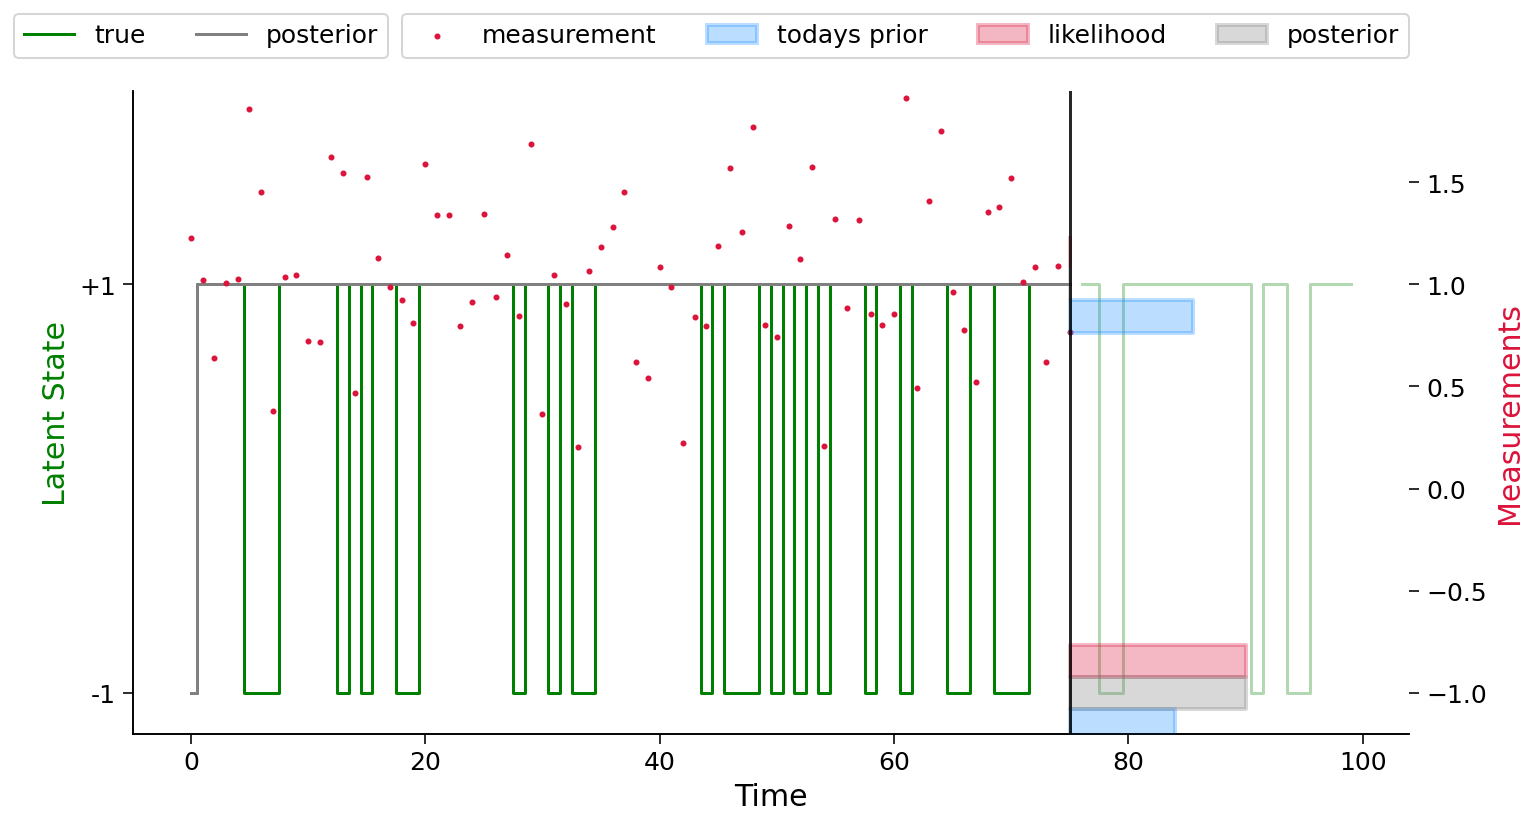

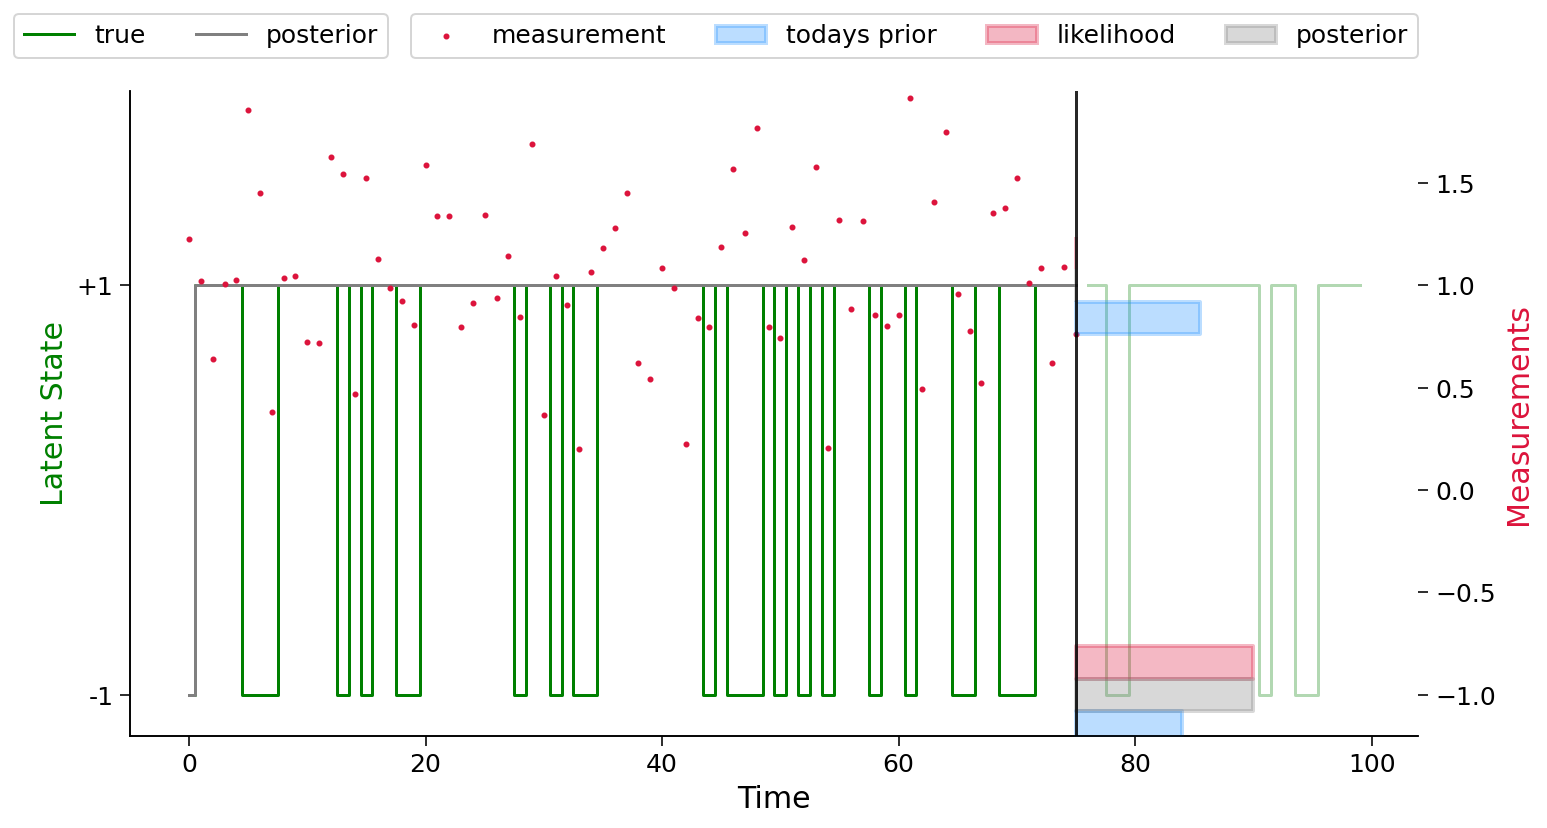

In [68]:
def simulate_forward_inference(means, var,T,start_probab, N, data):
  """
  Given the HMM model, calculate posterior marginal predictions of x_t for N-1 time steps ahead based on
  evidence `data`. 

  Args:
    means (array): Mean mesurement for each state [right, left].
    var (float): Variance of measurement models. Same for each state.
    T (numpy array): transition matrix of the HMM
    N (int): length of returned array
    data (numpy array): measurements vector

  Returns:
    predictive_probs (numpy array): predictive probabilities 
    likelihoods (numpy array): likelihood of seeing data M_t for all measurements models
    posterior_probs (numpy array): posterior probabilities 
  """
  
  #Initialize arrays
  predictive_probs = np.zeros((N,2))
  likelihoods = np.zeros((N,2))
  posterior_probs = np.zeros((N,2))

  ##########################
  ##### Your code here #####
  ##########################

  #Calculate marginal for each latent state x_t

  #Start with the first element
  predictive_probs[0,:] = start_probab
  likelihoods[0,:] = compute_likelihood(means,var,data[0])
  posterior = predictive_probs[0,:] * likelihoods[0,:]
  posterior /= np.sum(posterior)
  posterior_probs[0,:] = posterior

  #Then iterate for the rest of the N elements
  for t in range(1, N):
    prediction, likelihood, posterior = one_step_update(T, posterior_probs[t-1,:], data[t], means, var)
    # normalize and add to the list
    posterior /= np.sum(posterior)
    predictive_probs[t,:] = prediction
    likelihoods[t,:] = likelihood
    posterior_probs[t,:] = posterior

  return predictive_probs, likelihoods, posterior_probs

# Set random seed
np.random.seed(54)

# Set parameters
switch_proba = np.array([0.4, 0.7])
T = np.array([[1-switch_proba[0], switch_proba[0]],
                [switch_proba[1], 1-switch_proba[1]]])
start_proba = np.array([0, 1]) #The initial state is left (-1)
noise_level = .4
means = np.array([1, -1])
n_steps = 100
N = 75

# Create and sample from model
states = generate_state(switch_proba, start_proba, n_steps)
measurements = sample(means, noise_level**2, states)

# Infer state sequence
predictive_probs, likelihoods, posterior_probs = simulate_forward_inference(means, noise_level**2, T, start_proba, n_steps, measurements)
states_inferred = np.ones(n_steps)
states_inferred[posterior_probs[:,0] < 0.5] =-1

# Visualize
plot_forward_inference(
      noise_level, states, measurements, states_inferred,
      predictive_probs, likelihoods, posterior_probs,t=N, flag_m = 0
    )

##Interactive Demo 3.2: Forward inference in binary HMM
Now visualize your inference algorithm. Play with the sliders and checkboxes to help you gain intuition.

Use the sliders switch_RtoL, switch_LtoR and log10_noise_level to change the switching probabilities and measurement noise level.

Use the slider t to view prediction (prior) probabilities, likelihood, and posteriors at different times.

When does the inference make a mistake? 

In [69]:
# @markdown Execute this cell to enable the demo

nstep = 100

@widgets.interact
def plot_forward_inference_widget(
    switch_RtoL=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.05),
    switch_LtoR=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.05),
    log10_noise_level=widgets.FloatSlider(min=-1., max=1., step=.01, value=0.1),
    t=widgets.IntSlider(min=0, max=nstep-1, step=1, value=nstep//2),
    #flag_m=widgets.Checkbox(value=True, description='measurement distribution', disabled=False, indent=False),
    flag_d=widgets.Checkbox(value=True, description='measurements', disabled=False, indent=False),
    flag_pre=widgets.Checkbox(value=True, description='todays prior', disabled=False, indent=False),
    flag_like=widgets.Checkbox(value=True, description='likelihood', disabled=False, indent=False),
    flag_post=widgets.Checkbox(value=True, description='posterior', disabled=False, indent=False),
    ):

  np.random.seed(102)

  # global model, measurements, states, states_inferred, predictive_probs, likelihoods, posterior_probs
  switch_proba = np.array([switch_RtoL, switch_LtoR])
  start_proba = np.array([0, 1])
  means = np.array([1., -1.])
  var = np.ones(2) * 10.**log10_noise_level * 10.**log10_noise_level

  states = generate_state(switch_proba, start_proba, nstep)
  observations = sample(means, var[0], states)

  # Infer state sequence
  predictive_probs, likelihoods, posterior_probs = simulate_forward_inference(means, var[0], T, start_proba, nstep, observations)

  states_inferred = np.ones(n_steps)
  states_inferred[posterior_probs[:,0] < 0.5] =-1

  fig = plot_forward_inference(
      noise_level, states, measurements, states_inferred,
      predictive_probs, likelihoods, posterior_probs,t=t, flag_m = 0,
        flag_d=flag_d,flag_pre=flag_pre,flag_like=flag_like,flag_post=flag_post
      )
  plt.show(fig)

interactive(children=(FloatSlider(value=0.05, description='switch_RtoL', max=1.0, step=0.01), FloatSlider(valu…